 9. Train a classification model for the SketchRNN dataset, available in TensorFlow datasets


In [39]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from pathlib import Path
import matplotlib.pyplot as plt

In [4]:

tf_download_root = 'http://download.tensorflow.org/data/'
filename = 'quickdraw_tutorial_dataset_v1.tar.gz'
filepath = tf.keras.utils.get_file(filename, tf_download_root + filename, cache_dir='.', extract=True)

1065301781/1065301781 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [5]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(p) for p in (quickdraw_dir.glob('training.tfrecord-*'))])
valid_files = sorted([str(p) for p in (quickdraw_dir.glob('eval.tfrecord-*'))])

In [6]:
with open(quickdraw_dir / 'eval.tfrecord.classes') as test_classes_file:
    test_classes = test_classes_file.readlines()

with open(quickdraw_dir/'training.tfrecord.classes') as train_classes_file:
    train_classes = train_classes_file.readlines()



In [7]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [8]:
sorted(class_names)[:15]

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage']

let's know the stracture of the data

In [9]:
def inspect_record(tfrecord_file):
    raw_dataset = tf.data.TFRecordDataset([tfrecord_file])
    for raw_record in raw_dataset.take(1):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        print(example)

# Inspect a TFRecord
inspect_record('datasets/training.tfrecord-00000-of-00010')

features {
  feature {
    key: "shape"
    value {
      int64_list {
        value: 55
        value: 3
      }
    }
  }
  feature {
    key: "ink"
    value {
      float_list {
        value: 0.01968503
        value: 0.0509554148
        value: 0
        value: 0.0314961076
        value: 0.0318471193
        value: 0
        value: 0.122047246
        value: -0.0127388239
        value: 0
        value: 0.0669291
        value: -0.0509554148
        value: 0
        value: -0.015748024
        value: -0.133757979
        value: 0
        value: -0.0551181436
        value: -0.178343952
        value: 0
        value: -0.047244072
        value: -0.0445859879
        value: 0
        value: -0.043307066
        value: -0.00636942685
        value: 0
        value: -0.0590551496
        value: 0.0509554148
        value: 0
        value: -0.0905511677
        value: 0.191082805
        value: 0
        value: -0.003937006
        value: 0.114649653
        value: 0
        value: 

we can feed this stracture to any llm and ask for parsing function for easy using or extract the stracture manualy.

**Data stracture and further details about next function** in this disscussion:

https://chatgpt.com/share/6757b589-92bc-800a-8dfc-913c678f8f8d

In [20]:
feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }

def parse(data_batch):
  examples = tf.io.parse_example(data_batch, feature_descriptions)
  flat_sketches = tf.sparse.to_dense(examples['ink'])
  sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch),-1,3])#reshaping to (batchsize, number of points, the 3 is triplets x,y,t)
  lengths = examples['shape'][:,0]#selects number of points in each example over the batch
  labels = examples['class_index'][:,0]#this removes the extra dim
  return sketches, lengths, labels

In [26]:
def create_dataset(data_files, n_read_threads=5, buffer_size=None,seed=42,n_parse_threads=5, batch_size=32,
                   cache=False):
    dataset = tf.data.TFRecordDataset(data_files,num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if buffer_size:
        dataset = dataset.shuffle(buffer_size,seed=seed)
    dataset = dataset.batch(batch_size).map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [76]:
train_dataset = create_dataset(train_files)
valid_dataset = create_dataset(valid_files[:5])
test_dataset = create_dataset(valid_files[5:])

#### Visualize dataset

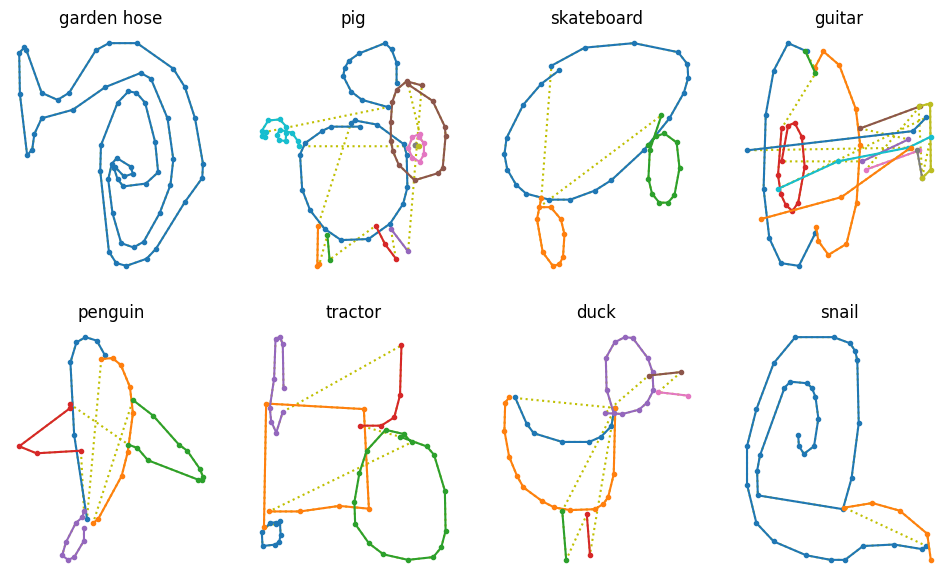

In [68]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = sketch[:, :2].cumsum(axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_dataset.take(1).unbatch().batch(8).take(1):
    draw_sketches(sketches, lengths, labels)

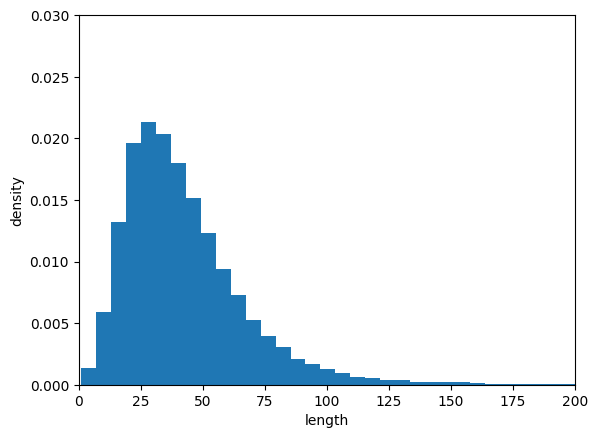

In [79]:
lengths = np.concatenate([lengths for _, lengths, _ in train_dataset.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [80]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

train_dataset = crop_long_sketches(train_dataset)
valid_dataset = crop_long_sketches(valid_dataset)
test_dataset = crop_long_sketches(test_dataset)

#### Training args

In [82]:
n_epochs = 20
optimizer = tf.keras.optimizers.Adam(0.01,clipnorm=1.)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
metrics=["accuracy", "sparse_top_k_categorical_accuracy"]

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_model.keras", save_best_only=True)

### Building the model

In [83]:
model  = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None,3)),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

In [84]:
model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)

In [ ]:
history = model.fit(train_dataset, validation_data = valid_dataset, batch_size=32, epochs=n_epochs)

Epoch 1/20
   1595/Unknown 27s 14ms/step - accuracy: 0.0037 - loss: 5.8774 - sparse_top_k_categorical_accuracy: 0.0172